In [20]:

import tensorflow as tf
import pandas as pd
import numpy as np
from keras.layers.wrappers import TimeDistributed
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout,Bidirectional

In [21]:
import pandas as pd
import numpy as np 
from PIL import Image
import os
from glob import glob 
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os 
import matplotlib.pyplot as plt
from PIL import Image, ImageOps


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AAPL.csv')

In [24]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-08-14,114.830002,115.000000,113.044998,114.907501,114.173164,165565200
1,2020-08-17,116.062500,116.087502,113.962502,114.607498,113.875069,119561600
2,2020-08-18,114.352501,116.000000,114.007500,115.562500,114.823975,105633600
3,2020-08-19,115.982498,117.162498,115.610001,115.707497,114.968048,145538000
4,2020-08-20,115.750000,118.392502,115.732498,118.275002,117.519142,126907200


In [25]:
train_dates=pd.to_datetime(df["Date"])

In [26]:
(train_dates)

0     2020-08-14
1     2020-08-17
2     2020-08-18
3     2020-08-19
4     2020-08-20
         ...    
247   2021-08-09
248   2021-08-10
249   2021-08-11
250   2021-08-12
251   2021-08-13
Name: Date, Length: 252, dtype: datetime64[ns]

In [27]:
col=list(df)[1:6]
df_training=df[col].astype(float)

In [28]:
df_training

,Open,High,Low,Close,Adj Close
0,114.830002,115.000000,113.044998,114.907501,114.173164
1,116.062500,116.087502,113.962502,114.607498,113.875069
2,114.352501,116.000000,114.007500,115.562500,114.823975
3,115.982498,117.162498,115.610001,115.707497,114.968048
4,115.750000,118.392502,115.732498,118.275002,117.519142
...,...,...,...,...,...
247,146.199997,146.699997,145.520004,146.089996,146.089996
248,146.440002,147.710007,145.300003,145.600006,145.600006
249,146.050003,146.720001,145.529999,145.860001,145.860001
250,146.190002,149.050003,145.839996,148.889999,148.889999


In [29]:
scaler=StandardScaler()
scaler=scaler.fit(df_training)
df_training=scaler.transform(df_training)

In [30]:
trainX=[]
trainY=[]

n_future=1
n_past=15


In [31]:
for i in range(n_past,len(df_training) - n_future+1):
  
  trainX.append(df_training[i-n_past:i, 0:df_training.shape[1]])
  trainY.append(df_training[i+n_future-1:i+n_future,0])


In [32]:
trainX=np.array(trainX)
trainY=np.array(trainY)

In [33]:
trainX.shape

(237, 15, 5)

In [ ]:
model=Sequential()
model.add(LSTM(256,activation="relu", input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(LSTM(64,activation="relu",return_sequences=True))
model.add(LSTM(32,activation="relu",return_sequences=True))
model.add(LSTM(16,activation="relu",return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

In [ ]:
history = model.fit(trainX, trainY, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

In [36]:
n_past = 16
n_days_for_prediction=50  #let us predict past 15 days
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()


In [ ]:
predict_period_dates=np.asarray(predict_period_dates)
predict_period_dates

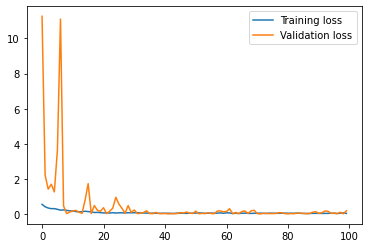

In [38]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [39]:
prediction = model.predict(trainX[-n_days_for_prediction:])

In [ ]:
prediction

In [41]:
prediction_copies = np.repeat(prediction, df_training.shape[1], axis=-1)

In [42]:
y_pred_future = scaler.inverse_transform(prediction_copies)

In [43]:
y_pred_future=y_pred_future[:,0]
y_pred_future

array([124.68695, 126.00365, 126.40102, 127.29284, 127.51081, 126.91617,
       127.33069, 130.1441 , 130.38965, 130.41791, 131.98268, 130.89355,
       132.00421, 134.03328, 134.01422, 133.60011, 133.03578, 134.71992,
       136.3031 , 137.03654, 136.78148, 140.30865, 142.4102 , 144.01047,
       139.06635, 145.70848, 144.00398, 145.25125, 149.88997, 142.34442,
       143.14528, 137.01189, 151.41736, 136.01804, 150.3839 , 144.04666,
       145.54184, 138.16994, 142.6825 , 146.48877, 140.3261 , 144.82527,
       147.3952 , 140.20734, 146.80583, 140.65306, 145.43735, 142.01004,
       144.53773, 149.90007], dtype=float32)

In [44]:
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
 

In [ ]:
forecast_dates

In [46]:
params={'Date':np.array(forecast_dates), 'Open':y_pred_future}

y_pred_future

array([124.68695, 126.00365, 126.40102, 127.29284, 127.51081, 126.91617,
       127.33069, 130.1441 , 130.38965, 130.41791, 131.98268, 130.89355,
       132.00421, 134.03328, 134.01422, 133.60011, 133.03578, 134.71992,
       136.3031 , 137.03654, 136.78148, 140.30865, 142.4102 , 144.01047,
       139.06635, 145.70848, 144.00398, 145.25125, 149.88997, 142.34442,
       143.14528, 137.01189, 151.41736, 136.01804, 150.3839 , 144.04666,
       145.54184, 138.16994, 142.6825 , 146.48877, 140.3261 , 144.82527,
       147.3952 , 140.20734, 146.80583, 140.65306, 145.43735, 142.01004,
       144.53773, 149.90007], dtype=float32)

In [47]:
df_forecast=y_pred_future
df_forecast.shape

(50,)

In [48]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])



In [49]:
original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
original=original.loc[60:,:]

In [51]:
y_pred_future

array([124.68695, 126.00365, 126.40102, 127.29284, 127.51081, 126.91617,
       127.33069, 130.1441 , 130.38965, 130.41791, 131.98268, 130.89355,
       132.00421, 134.03328, 134.01422, 133.60011, 133.03578, 134.71992,
       136.3031 , 137.03654, 136.78148, 140.30865, 142.4102 , 144.01047,
       139.06635, 145.70848, 144.00398, 145.25125, 149.88997, 142.34442,
       143.14528, 137.01189, 151.41736, 136.01804, 150.3839 , 144.04666,
       145.54184, 138.16994, 142.6825 , 146.48877, 140.3261 , 144.82527,
       147.3952 , 140.20734, 146.80583, 140.65306, 145.43735, 142.01004,
       144.53773, 149.90007], dtype=float32)

In [52]:
original.shape

(192, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


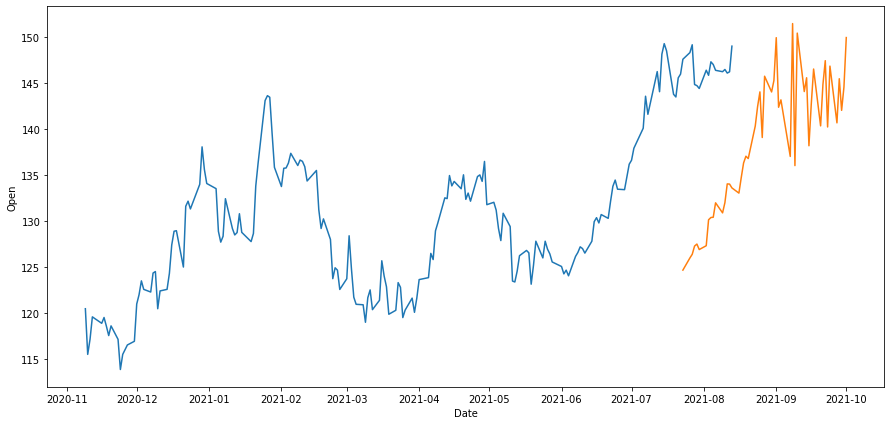

In [53]:
import seaborn as sns
plt.figure(figsize=[15,7])
sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


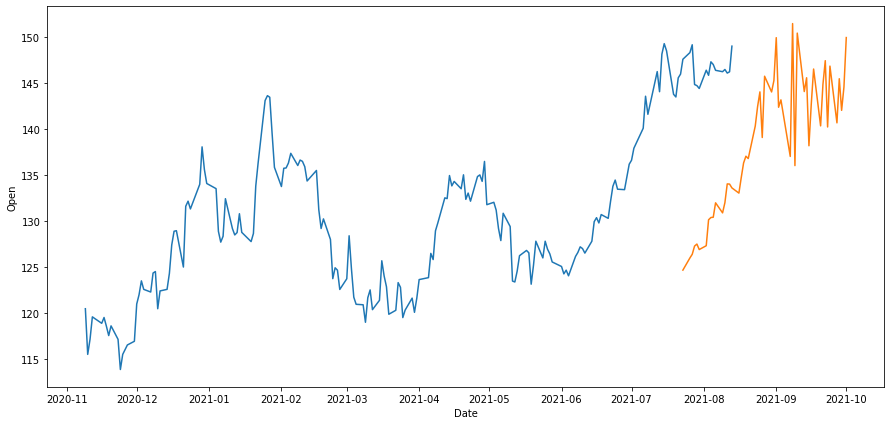

In [54]:
plt.figure(figsize=[15,7])
sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])